In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_hex
from matplotlib.ticker import FixedLocator
import json
import bgp_qnm_fits as bgp

special_color_1 = to_hex("#8B5FBF")
special_color_2 = to_hex("#C26C88")
special_color_3 = to_hex("#DE6A5E")

DATA_TYPE = 'news'
T = 100
INCLUDE_CHIF = True
INCLUDE_MF = True

NUM_SAMPLES = 1000

In [6]:
def get_fits(sim_id, mode_content_data_dict, t0_vals, full_modes_list, spherical_modes): 
    sim = bgp.SXS_CCE(sim_id, type=DATA_TYPE, lev="Lev5", radius="R2")
    tuned_param_dict_GP = bgp.get_tuned_param_dict("GP", data_type=DATA_TYPE)[sim_id]

    full_modes_list = [list(map(tuple, inner_list)) for inner_list in mode_content_data_dict["modes"]]
    unique_modes = {mode for modes in full_modes_list for mode in modes}

    fits = [] 

    fits_full = bgp.BGP_fit_lite(sim.times, 
                                sim.h, 
                                unique_modes, 
                                sim.Mf, 
                                sim.chif_mag, 
                                tuned_param_dict_GP, 
                                bgp.kernel_GP, 
                                t0=t0_vals, 
                                T=T, 
                                num_samples=NUM_SAMPLES,
                                spherical_modes = spherical_modes,
                                include_chif=INCLUDE_CHIF,
                                include_Mf=INCLUDE_MF,
                                data_type=DATA_TYPE)

    for i, t0 in enumerate(t0_vals): 

        print(f'Fitting from {t0=}')

        select_modes = full_modes_list[i]
        fits.append(bgp.BGP_fit_lite(sim.times, 
                                    sim.h, 
                                    select_modes, 
                                    sim.Mf, 
                                    sim.chif_mag, 
                                    tuned_param_dict_GP, 
                                    bgp.kernel_GP, 
                                    t0=t0, 
                                    T=T, 
                                    num_samples=NUM_SAMPLES,
                                    spherical_modes = spherical_modes,
                                    include_chif=INCLUDE_CHIF,
                                    include_Mf=INCLUDE_MF,
                                    data_type=DATA_TYPE)
                    )
                        
    
    return fits, fits_full

In [7]:
sim_id = "0012"

with open(f'mode_content_files/mode_content_data_{sim_id}.json', 'r') as f:
            mode_content_data_dict = json.load(f)

t0_vals = np.array(mode_content_data_dict['times'])
spherical_modes = [tuple(mode) for mode in mode_content_data_dict['spherical_modes']]

sim = bgp.SXS_CCE(sim_id, type=DATA_TYPE, lev="Lev5", radius="R2")
Mf_ref, chif_ref = sim.Mf, sim.chif_mag

full_modes_list = [list(map(tuple, inner_list)) for inner_list in mode_content_data_dict["modes"]]
fits, fits_full = get_fits(sim_id, mode_content_data_dict, t0_vals, full_modes_list, spherical_modes)

Fitting at t0 values: 100%|██████████| 31/31 [13:24<00:00, 25.96s/it]


Fitting from t0=0.0
Fitting from t0=2.0
Fitting from t0=4.0
Fitting from t0=6.0
Fitting from t0=8.0
Fitting from t0=10.0
Fitting from t0=12.0
Fitting from t0=14.0
Fitting from t0=16.0
Fitting from t0=18.0
Fitting from t0=20.0
Fitting from t0=22.0
Fitting from t0=24.0
Fitting from t0=26.0
Fitting from t0=28.0
Fitting from t0=30.0
Fitting from t0=32.0
Fitting from t0=34.0
Fitting from t0=36.0
Fitting from t0=38.0
Fitting from t0=40.0
Fitting from t0=42.0
Fitting from t0=44.0
Fitting from t0=46.0
Fitting from t0=48.0
Fitting from t0=50.0
Fitting from t0=52.0
Fitting from t0=54.0
Fitting from t0=56.0
Fitting from t0=58.0
Fitting from t0=60.0


In [ ]:
def get_amplitude_stability_plot(sim_id, mode_content_data_dict, Mf_ref, chif_ref, t0_vals):
    fig, ax_main = plt.subplots(figsize=(12, 8), dpi=300)

    p_values = mode_content_data_dict["p_values"]
    threshold_idx = next((i for i, p in enumerate(p_values) if p < 0.9), None)
    if threshold_idx is not None:
        ax_main.axvspan(0, t0_vals[threshold_idx], color='grey', alpha=0.5, zorder=0)

    epsilons_adaptive = np.zeros((len(t0_vals), NUM_SAMPLES))
    epsilons_full = np.zeros((len(t0_vals), NUM_SAMPLES))

    for i, t0 in enumerate(t0_vals):
        Mf_adaptive, chif_adaptive = fits[i].fit["samples"][:, -1], fits[i].fit["samples"][:, -2]
        Mf_full, chif_full = fits_full.fits[i]["samples"][:, -1], fits_full.fits[i]["samples"][:, -2]
        epsilon_adaptive = np.sqrt((Mf_ref - Mf_adaptive)**2 / Mf_ref**2 + (chif_ref - chif_adaptive)**2 / chif_ref**2)
        epsilon_full = np.sqrt((Mf_ref - Mf_full)**2 / Mf_ref**2 + (chif_ref - chif_full)**2 / chif_ref**2)
        epsilons_adaptive[i, :] = epsilon_adaptive
        epsilons_full[i, :] = epsilon_full

    print(epsilons_full) 

    median_adaptive = np.median(epsilons_adaptive, axis=1)
    p16_adaptive = np.percentile(epsilons_adaptive, 16, axis=1)
    p84_adaptive = np.percentile(epsilons_adaptive, 84, axis=1)
    median_full = np.median(epsilons_full, axis=1)
    p16_full = np.percentile(epsilons_full, 16, axis=1)
    p84_full = np.percentile(epsilons_full, 84, axis=1)

    ax_main.plot(t0_vals, median_adaptive, color='k', label="Adaptive model")
    ax_main.fill_between(t0_vals, p16_adaptive, p84_adaptive, color='k', alpha=0.3)
    ax_main.plot(t0_vals, median_full, color='b', label="All modes")
    ax_main.fill_between(t0_vals, p16_full, p84_full, color='b', alpha=0.3)

    ax_main.legend(frameon=False, loc="upper right", fontsize=8)
    ax_main.set_xlim([t0_vals[0], t0_vals[-1]])
    ax_main.set_xlabel(r"$t_0$ [M]")
    ax_main.set_ylabel(r"$\epsilon$")
    ax_main.set_yscale("log")

NameError: name 'epsilons_full' is not defined

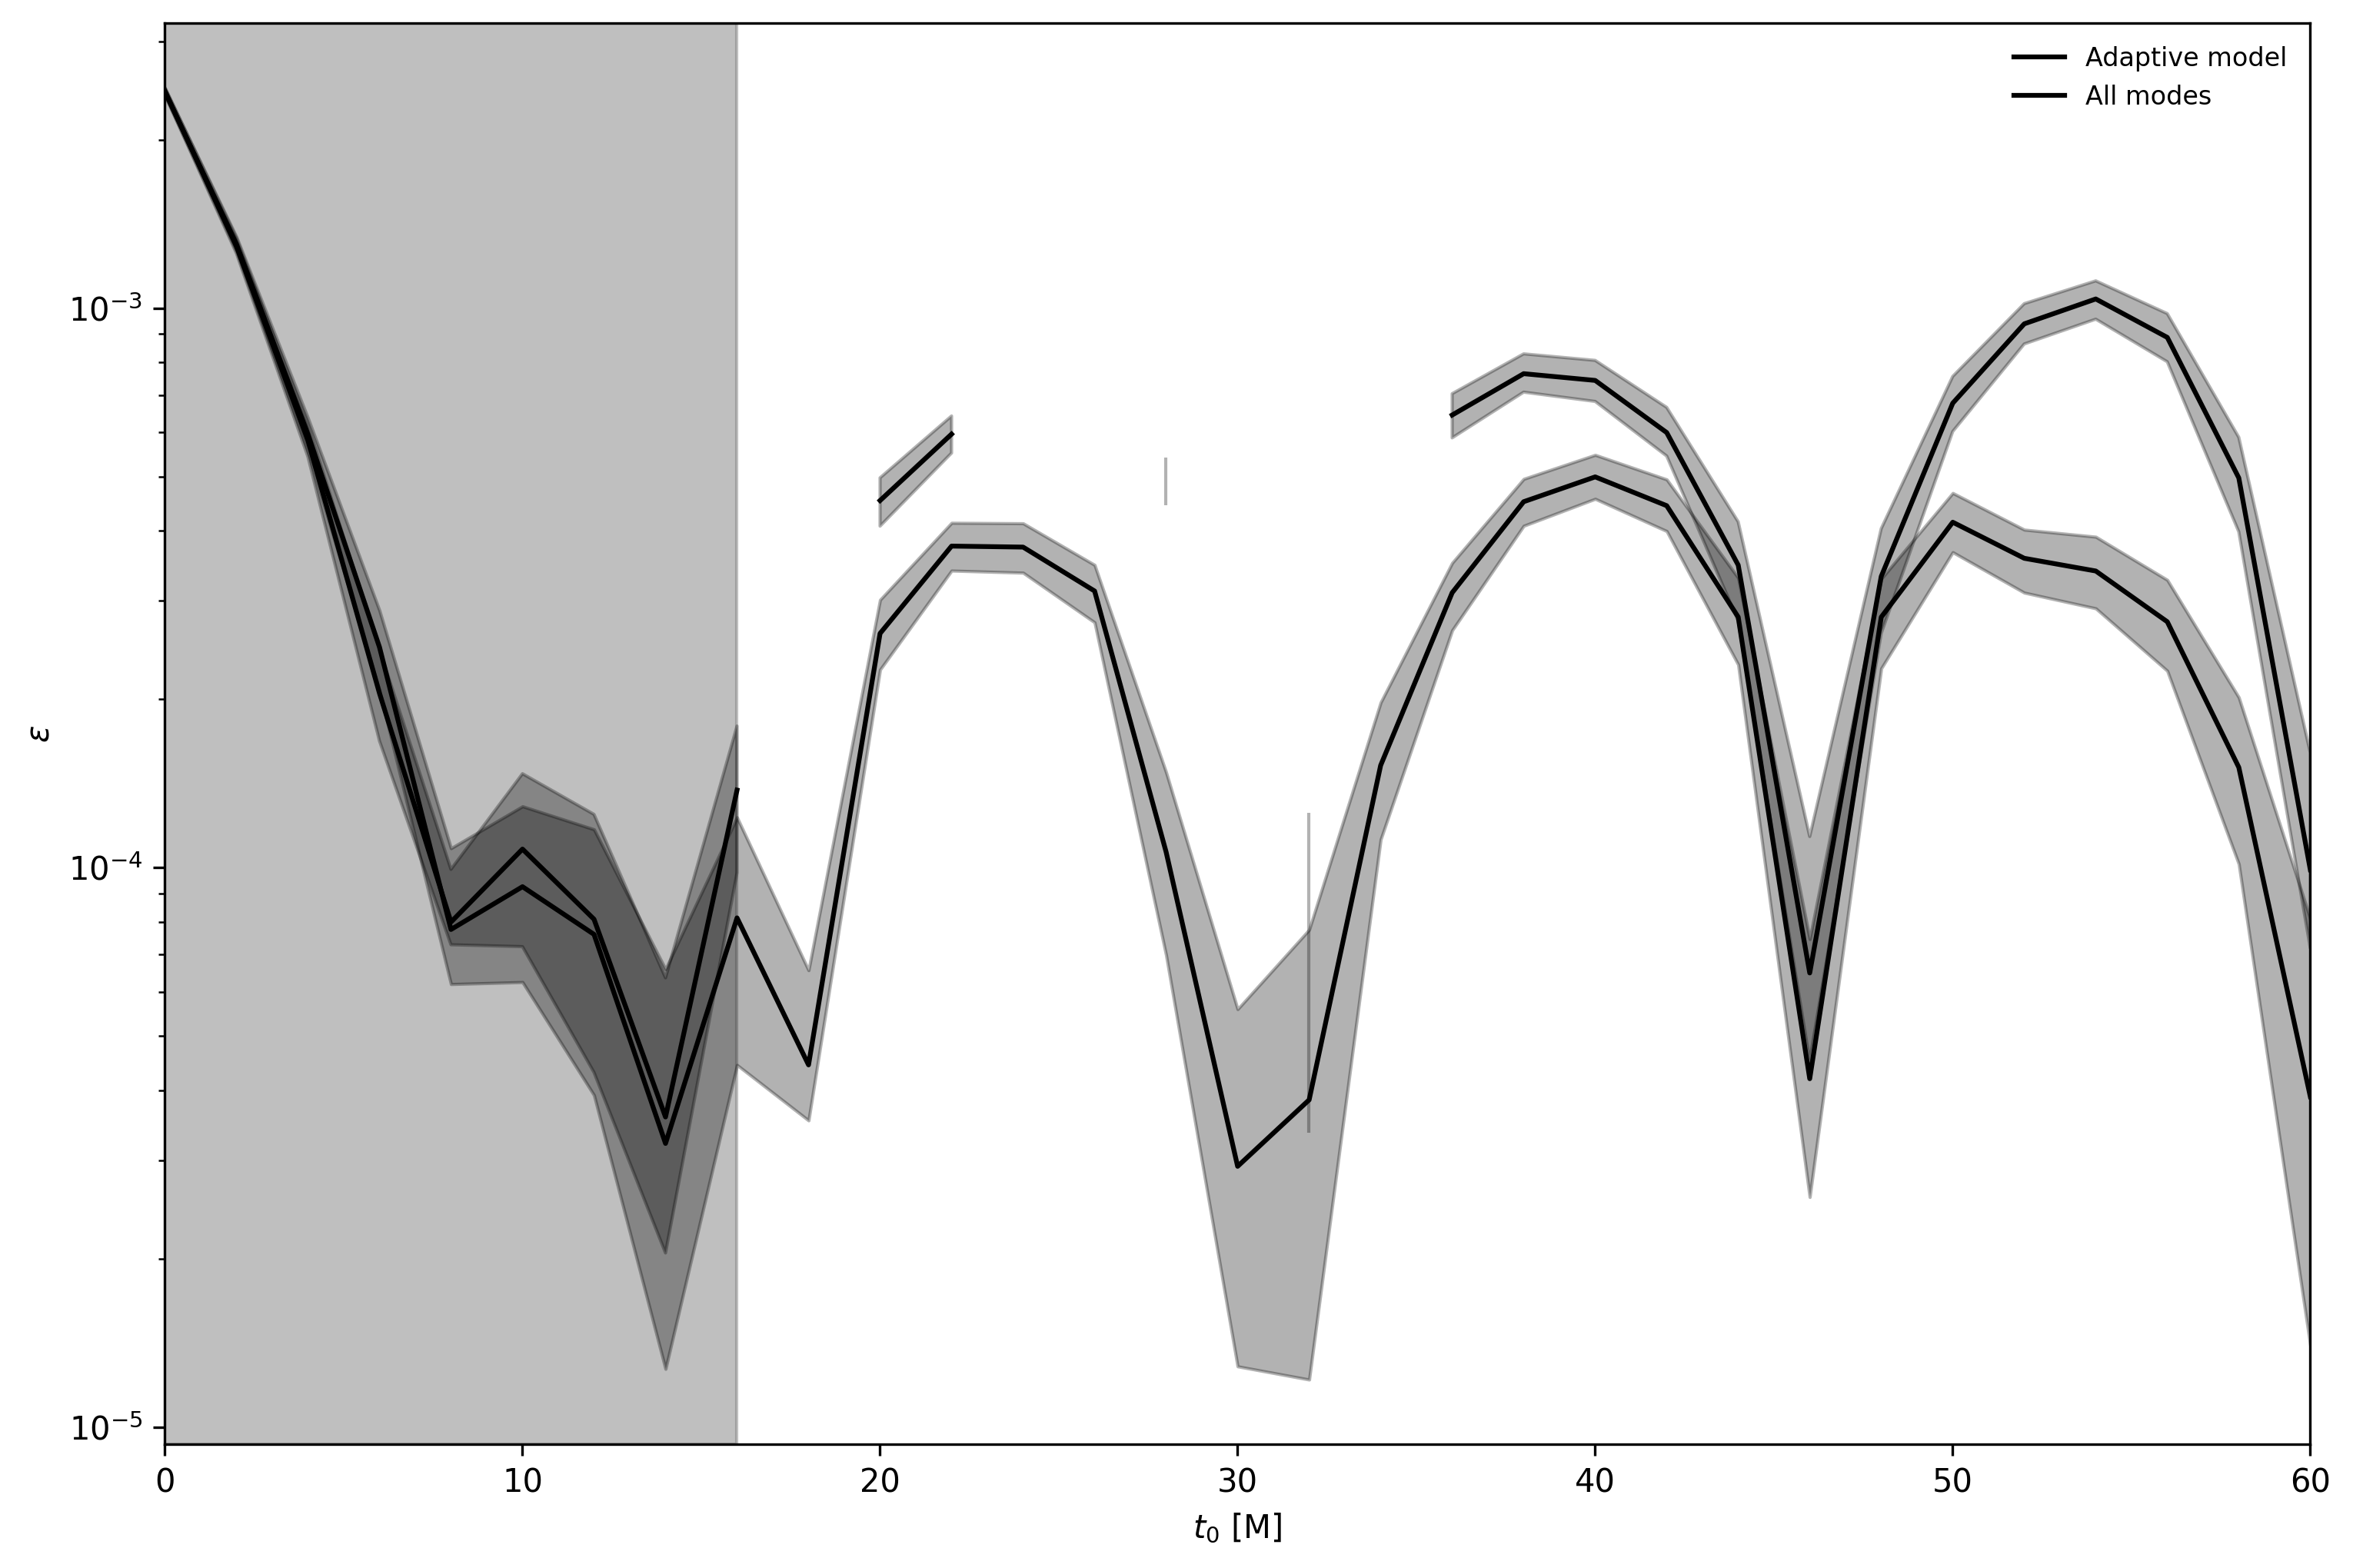

In [17]:
get_amplitude_stability_plot(sim_id, mode_content_data_dict, Mf_ref, chif_ref, t0_vals)